# **TP 2 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

# **Problema 2  - Circuito**

$\quad$Considere-se um circuito booleano $\,\mathcal{C}\,$ com $\,n\,$ “wires” de “input” e um único “wire” de output.
* O circuito é descrito num digrafo com uma classe de nodos representando “gates” e a segunda classe representando “wires” . 
* Cada nodo contém um campo val cujo conteúdo descreve a semântica desse nodo; para os “wires” o campo val  contém uma variável SCIP; para as “gates” o campo val  contém uma marca bo conjunto and, or,  xor e not,   que indica o tipo de “gate”. 
* Com exceção de not , que é um operador unário, todas as restantes “gates” têm um número arbitrário de “inputs” e um único “output”.
* No grafo os arcos com origem numa determinada “gate”  têm destino nos “wires” que são “input” dessa “gate”. Cada “wire” que não é “input” é origem de um único arco que tem como destino a “gate” do qual esse “wire” é “output”.
* A semântica das várias “gates” é expressa em relações na Aritmética Linear Inteira, tal como está descrita em +Capítulo 2: Programação com Restrições (#LIA)

$\quad$a. Escreva um programa que, a partir do número $\,n\,$ de “inputs”  e de um parâmetro positivo $\,\gamma\ll 1\,$ como argumentos,  gere aleatoriamente circuitos com “gates” or, and e not  em que o número de and's é  $\,\gamma\ast\,$ (número total de nodos).<br>

$\quad$b. Escreva um programa Python que leia um circuito arbitrário descrito pelo digrafo anterior e formule as restrições (em Programação Inteira) que descrevem as várias “gates” do circuito.<br>

$\quad$c. Usando os dois programas anteriores e o sistema SCIP:<br> 
$\qquad$c1. Escreva um programa que determine um vetor de “inputs”   $\,x\in\{0,1\}^n\,$ aceite pelo circuito (i.e. o respetivo output é $1$).<br>
$\qquad$c2. Determine o vetor $x'\neq x$ , também aceite pelo circuito, que está mais próximo de $x$.

In [2]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

## **Função que gera circuitos aleatoriamente**

Primeiramente, foram selecionados aleatoriamente os números de gates *xor*, *or* e *not*, e o número de gates *and* com base no valor de $\gamma$ de forma que $\#\mbox{and} = \gamma \ \times \ (\#\mbox{xor} \times \#\mbox{or} \times \#\mbox{not} \times \#\mbox{and})$

De seguida, foi criado um digrafo ao qual adicionamos os nodos que representam os "inputs", as "gates" e os "wires" (que são os "outputs" de cada "gate").

Para cada "gate" foi adicionado um "wire" e uma aresta da "gate" para tal "wire". Todos os nodos foram etiquetados de forma a identificar sua função no circuito (`"INPUT", "AND", "NOT", "OR", "XOR", "WIRE", "OUTPUT"`). As "gates" e seus respetivos "outputs" foram, ainda, etiquetadas com o nível a que pertencem no circuito, de forma a auxiliar na construção do mesmo.

Para ligar as várias "gates", foi utilizada uma técnica similar à travessia de grafos, usando uma `orla`, cujo primeiro elemento é a "gate" que está ligada ao "wire" identificado como "output" do circuito. Após selecionar e remover o nodo $g_1$ mais antigo da `orla` há dois casos:

1. $g_1$ é um "NOT". Então, é criada uma aresta $(w, g_1)$, onde $w$ é uma "wire", "output" de uma "gate" de nível superior ao de $g_1$ escolhida de forma aleatória.

2. $g_1$ não é um "NOT". Então, são criadas $n$ de arestas $(w_2, g_1), \dotsc, (w_n, g_1)$, onde $2 \leq n \leq \mbox{número de "gates" de nível superior}$, e, para cada $2 \leq i \leq n$, $w_i$ é um "wire", "output" de uma "gate" de nível superior ao de $g_1$ escolhida de forma aleatória.

Todas as "gates" selecionadas neste passo são adicionadas à `orla` e o processo termina quando a `orla` fica vazia.

Como deste processo podem resultar "wires" que não se encontram ligados ao circuito, é realizado um ciclo para estabelecer as ligações necessárias para que o circuito faça sentido. Além disso, são ligados os nodos de "inputs", à sorte, às "gates" cujo grau de incidência é igual a $0$, no caso de "gates" *not*, ou $< 2$ para as restantes "gates".

In [3]:
def circuit_generator(I,Gamma):
    
    if Gamma != 1:
        num_xors = random.randint(1,I)
        num_nots = random.randint(1,I)
        num_ors = random.randint(1,I)
        num_ands = int((num_xors + num_nots + num_ors) * Gamma / (1-Gamma))
    else:
        num_xors = 0
        num_nots = 0
        num_ors = 0
        num_ands = 1
        
    G = nx.DiGraph()
    total = 0
    
    #adicionar e etiquetar aos varios nodos do grafo
    
    for n in range(I):
        G.add_node(n,type="INPUT",val=None)
    
    total += I
    
    for n in range(num_xors):
        G.add_node(total+n,type="XOR")
    
    total += num_xors
    
    for n in range(num_nots):
        G.add_node(total+n,type="NOT")
    
    total += num_nots
    
    
    for n in range(num_ors):
        G.add_node(total+n,type="OR")
    
    total += num_ors
    
    for n in range(num_ands):
        G.add_node(total+n,type="AND")
    
    total+= num_ands
    
    num_gates = total - I
    
    for n in range(num_gates):
        G.add_node(total+n,type="WIRE",val=None)
    
    gates = [n for n in G.nodes() if G.nodes[n]['type'] != 'INPUT' and G.nodes[n]['type'] != 'WIRE']
    wires = [n for n in G.nodes() if G.nodes[n]['type'] == 'WIRE']
    random.shuffle(gates)
    gates_info = {}
    
    # ligar cada gate ao seu wire de output 
    
    for edge in zip(gates,wires):
        G.add_edge(*edge)
        gates_info[edge[0]] = {'type':G.nodes[edge[0]]['type'] ,'output':edge[1],'level':float('inf')}
    
    output = random.choice(gates)
    G.nodes[gates_info[output]['output']]['type'] = 'OUTPUT'
    gates_info[output]['level'] = 1
    
    #criar o circuito ligando as varias gates
    
    orla = [output]
    while orla:
        x = orla.pop(0)
        candidates = [g for g in gates_info if gates_info[g]['level'] > gates_info[x]['level']]
        if candidates:
            random.shuffle(candidates)
            if gates_info[x]['type'] == 'NOT':
                selected = candidates.pop(0)
                gates_info[selected]['level'] = gates_info[x]['level'] +1 
                G.add_edge(gates_info[selected]['output'],x)
                orla.append(selected)
            elif len(candidates)>1:
                for i in range(random.randint(2,len(candidates))):
                    selected = candidates.pop(0)
                    gates_info[selected]['level'] = gates_info[x]['level'] +1 
                    G.add_edge(gates_info[selected]['output'],x)
                    orla.append(selected)

            
    # ligar gates que não se encontram ligadas ao circuito, ou seja, o grau de saida do nodo de output é 0
    
    unconected = [n for n in gates if G.out_degree[gates_info[n]['output']] == 0 and G.nodes[gates_info[n]['output']]['type']!= 'OUTPUT']
    for x in unconected:
        candidates = [n for n in gates if n not in unconected and G.nodes[n]['type'] != 'NOT']
        selected = random.choice(candidates)
        G.add_edge(gates_info[x]['output'],selected)
    
    # ligar gates cujo grau de incidencia é 0 aos nodos de input do circuito
    
    unconected = [n for n in gates if G.in_degree[n] == 0]
    
    for x in unconected:
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT']
        random.shuffle(candidates)
        if gates_info[x]['type'] == 'NOT':
            selected = candidates.pop(0)
            G.add_edge(selected,x)
        else:
            for i in range(random.randint(1,len(candidates))):
                selected = candidates.pop(0)
                G.add_edge(selected,x)
                
    # ligar gates NOT, XOR, AND cujo grau de incidenci é 1 aos nodos de input do circuito
    
    unconected = [n for n in gates if G.in_degree[n] == 1 and (G.nodes[n]['type'] == 'OR' or G.nodes[n]['type'] == 'XOR' or G.nodes[n]['type'] == 'AND')]
    for x in unconected:   
        candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'INPUT' and (i,x) not in G.edges()]
        if not candidates:
            candidates = [i for i in G.nodes() if G.nodes[i]['type'] == 'WIRE' and not nx.has_path(G,x,i)]
        selected = random.choice(candidates)
        G.add_edge(selected,x)
        
    # ligar nodos de input do circuito que ainda se encontram desconectados a gates com aridade superior a 1
    
    unconected = [n for n in G if G.nodes[n]['type'] == 'INPUT' and G.out_degree(n) == 0]
    candidates = [i for i in gates if G.nodes[i]['type'] != 'NOT']
    for x in unconected:
        selected = random.choice(candidates)
        G.add_edge(x,selected)
    

    return G

## **Formular as restrições que descrevem as "gates" do circuito**

Para formular as restrições, utilizaremos um *solver* SCIP, ao qual chamaremos `solver`, e um dicionário $X$ para guardar as variáveis binárias correspondentes aos nodos dos tipos `"INPUT"`, `"WIRE"` e `"OUTPUT"`. Criaremos, também, uma variável inteira $T$ para auxiliar no caso das "gates" do tipo `"XOR"`.

A primeira coisa a ser feita é inverter o circuito, ou seja, o "output" do circuito, que estava no primeiro nível até agora, deve estar no último nível.

De seguida, iteramos por todos os nodos dos tipos `"WIRE"` e `"OUTPUT"`. Para cada nodo $n$ destes, identificamos a que nodo $f$ o $n$ se encontra ligado, ou seja, a "gate" $f$ da qual $n$ é "output". Também criamos a lista $L$ que contém todos os nodos aos quais $f$ se encontra ligado (em outras palavras, $L$ é a lista de "inputs" de $f$).

Finalmente, temos quatro casos:

1. $f$ é do tipo `"AND"`. Então, $X_n = 1 \  \mbox{se e só se} \  \forall_{i \in L} \cdot X_i = 1$, ou seja,

>$\forall_{i \in L} \cdot X_i \geq X_n \quad \land \quad \sum_{i \in L} X_i < \mbox{len}(L) + X_n$

2. $f$ é do tipo `"NOT"`. Então, $L$ tem um único elemento $i$ e $(X_i = 0 \Rightarrow X_n = 1) \ \land \ (X_i = 1 \Rightarrow X_n = 0)$, ou seja, 

>$X_n = 1 - X_i$

3. $f$ é do tipo `"OR"`. Então, $X_n = 1 \  \mbox{se e só se} \ \exists_{i \in L} \cdot X_i = 1$, ou seja,

>$\forall_{i \in L} \cdot X_i \leq X_n \quad \land \quad \sum_{i \in L} X_i \geq X_n$

4. $f$ é do tipo `"XOR"`. Então, $X_n = 1 \ \mbox{se e só se} \ \sum_{i \in L} X_i \ \mbox{é impar}$, ou seja,

>$X_n = (\sum_{i \in L} X_i) - 2 \times T$, para algum $T \in \mathbb{N} \ \cup \{0\}$.

>**Nota:** como $T$ é uma variável inteira do *solver*, o mesmo procura um valor entre $[0, +\infty[$ até que o valor de $X_n$ seja $0$ ou $1$.

A função retorna o `solver` e o dicionário $X$.

In [4]:
def add_restrictions(G):
    G = G.reverse()
    solver = pywraplp.Solver.CreateSolver('SCIP')
    variables = [n for n in G.nodes() if G.nodes[n]['type']=='INPUT' or G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    X = {}
    for n in variables:
        X[n] = solver.BoolVar(str(n))
    wires = [n for n in G if G.nodes[n]['type']=='WIRE' or G.nodes[n]['type']=='OUTPUT']
    for n in wires:
        father = list(G.neighbors(n)).pop()
        father_input = list(G.neighbors(father))
        if G.nodes[father]['type'] == "OR":
            solver.Add(sum([X[i] for i in father_input]) >= X[n])
            for i in father_input:
                solver.Add(X[n] >= X[i])
        elif G.nodes[father]['type'] == "AND":
            solver.Add(sum([X[i] for i in father_input]) <= X[n] + len(father_input) -1)
            for i in father_input:
                solver.Add(X[n] <= X[i])
        elif G.nodes[father]['type'] == "NOT":
            solver.Add(X[n] == 1 - X[father_input[0]])
        elif G.nodes[father]['type'] == "XOR":
            T = solver.IntVar(0,solver.infinity(),"XOR"+str(father))
            solver.Add(X[n] == sum([X[i] for i in father_input]) - 2*T)
    return solver, X

## Função que calcula vetor de "inputs" $x$ aceite pelo circuito
Para calcular, temos que adicionar mais uma restrição e uma função objetivo ao *solver*.

Primeiro, como queremos que o vetor de "inputs" seja aceite, temos que garantir que $X_o = 1$, sendo $o$ o nodo do tipo `"OUTPUT"` do circuito.

Agora, o nosso objetivo é encontrar um vetor de "inputs" aceite pelo circuito, portanto nossa função objetivo é minimizar $\sum_{i \in I} X_i$, onde $I$ é a lista dos nodos do tipo `"INPUT"`.

In [5]:
def calculate_input(G):
    solver,X = add_restrictions(G)
    output = [n for n in G if G.nodes[n]['type'] == 'OUTPUT'].pop()
    inputs = [n for n in G if G.nodes[n]['type'] == 'INPUT']
    solver.Add(X[output] == 1)
    solver.Minimize(sum([X[n] for n in inputs]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        result = [round(X[i].solution_value()) for i in inputs]
        for n in X:
            G.nodes[n]['val'] = round(X[n].solution_value())
        return result
    else:
        return None

## Função que calcula o vetor de "inputs" $x'\neq x$ aceite pelo circuito, que está mais próximo de $x$
Esta função, para além do circuito, recebe o vetor de "inputs" $x$ aceite pelo circuito. 

Para calcular o vetor $x'$, temos que criar um dicionário de erro $E$, que vai armazer variáveis binárias. O número de elementos de $E$ é igual ao comprimento do vetor $x$. Também serão utilizadas variáveis auxiliares do tipo inteiro, às quais chamaremos $T$.

Temos, agora mais duas restrições:

1. O novo valor de cada "input" do circuito é calculado através de um *xor* entre a variável de erro e o correspondente valor da solução $x$.

> $\forall_{1 \leq n \leq N} \cdot X_{I_n} = E_n + x_n - 2 \times T$, onde $N = \mbox{len}(x)$ e $T \in [0, +\infty[$

2. Para garantir que $x' \neq x$, precisamos ter pelo menos uma mudança nos valores do vetor $x$.

> $\sum_{e \in E} e \ \geq 1$

E, como queremos a solução mais próxima de $x$, vamos minimizar $\sum_{e \in E} e$.

In [6]:
def next_solution(G,S):
    if not S:
        return None
    solver,X = add_restrictions(G)
    E = {}
    output = [n for n in G if G.nodes[n]['type'] == 'OUTPUT'].pop()
    inputs = [n for n in G if G.nodes[n]['type'] == 'INPUT']
    solver.Add(X[output] == 1)
    solver.Minimize(sum([X[n] for n in inputs]))
    for i in range(len(inputs)):
        E[i] = solver.BoolVar("e"+str(i))
        T = solver.IntVar(0,solver.infinity(),"T"+str(i))
        solver.Add(E[i] + S[i] == X[inputs[i]] + 2*T )
    solver.Add(sum([E[n] for n in E]) >=1)
    solver.Minimize(sum([E[n] for n in E]))
    
    status = solver.Solve()
    
    if status == pywraplp.Solver.OPTIMAL:
        result = [round(X[i].solution_value()) for i in inputs]
        for n in X:
            G.nodes[n]['val'] = round(X[n].solution_value())
        return result
    else:
        return None
    

## Função que imprime o circuito

In [7]:
def draw_circuit(C):
    pos = nx.nx_pydot.graphviz_layout(C)
    labels = {}
    colors = [None for n in C.nodes]
    for n in C:
        if C.nodes[n]['type'] == 'INPUT':
            if C.nodes[n]['val'] != None:
                labels[n] = C.nodes[n]['val']
            else:
                labels[n] = chr(ord('A') + n)
            colors[n] = "turquoise"
        elif C.nodes[n]['type'] == 'OUTPUT':
            labels[n] = 'OUT'
            colors[n] = "blue"
        elif C.nodes[n]['type'] == 'XOR':
            labels[n] = 'XOR'
            colors[n] = "orange"
        elif C.nodes[n]['type'] == 'NOT':
            labels[n] = 'NOT'
            colors[n] = "red"
        elif C.nodes[n]['type'] == 'OR':
            labels[n] = 'OR'
            colors[n] = "pink"
        elif C.nodes[n]['type'] == 'AND':
            labels[n] = 'AND'
            colors[n] = "yellow"
        else:
            if C.nodes[n]['val'] != None:
                labels[n] = C.nodes[n]['val']
            else:
                labels[n] = "W"
            colors[n] = "grey"
            
    nx.draw(C, pos=pos, with_labels=True, labels=labels, font_size=8, node_size=700, node_color=colors)
            

## Exemplo 1

#### Gerar circuito

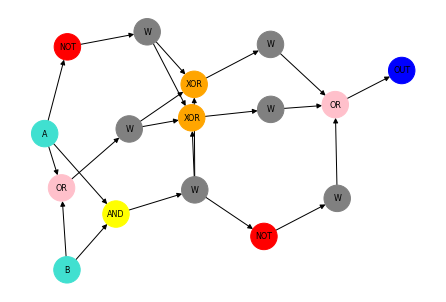

In [31]:
C = circuit_generator(2,0.2)
draw_circuit(C)

#### Calcular vetor de input X aceite pelo circuito

X = [0, 0]


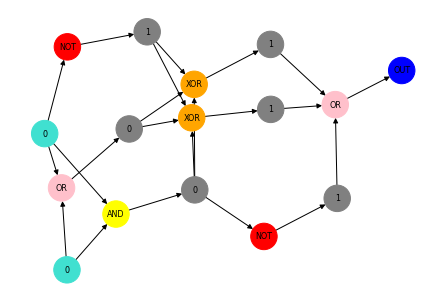

In [32]:
S = calculate_input(C)
if S:
    draw_circuit(C)
print("X =",S)

#### Calcular vetor de input X' aceite pelo circuito que está mais próximo de X

X' = [1, 0]


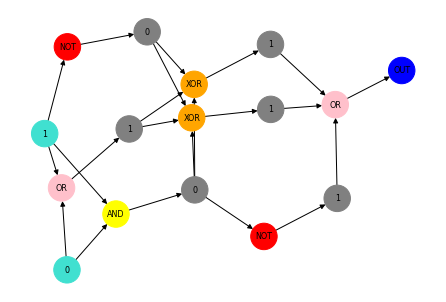

In [33]:
NS = next_solution(C,S)
if NS:
    draw_circuit(C)
print("X' =", NS)

## Exemplo 2

#### Gerar circuito

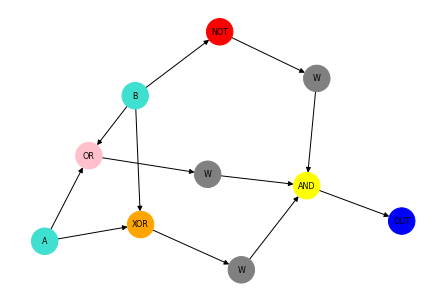

In [37]:
C = circuit_generator(2,0.3)
draw_circuit(C)

#### Calcular vetor de input X aceite pelo circuito

X = [1, 0]


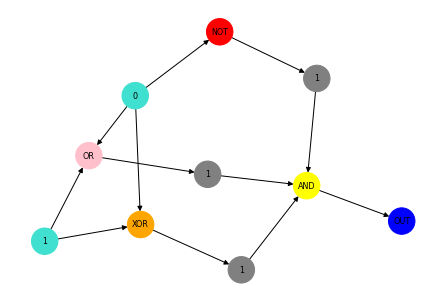

In [38]:
S = calculate_input(C)
if S:
    draw_circuit(C)
print("X =",S)

#### Calcular vetor de input X' aceite pelo circuito que está mais próximo de X

In [39]:
NS = next_solution(C,S)
if NS:
    draw_circuit(C)
print("X'=", NS)

X'= None


## Exemplo 3

#### Gerar circuito

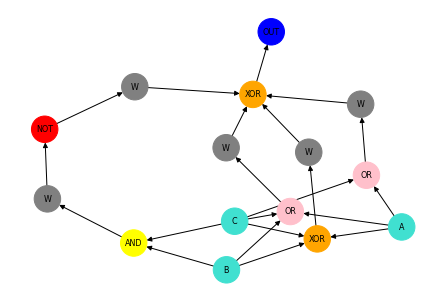

In [19]:
C = circuit_generator(3,0.2)
draw_circuit(C)

#### Calcular vetor de input X aceite pelo circuito

X = [0, 0, 0]


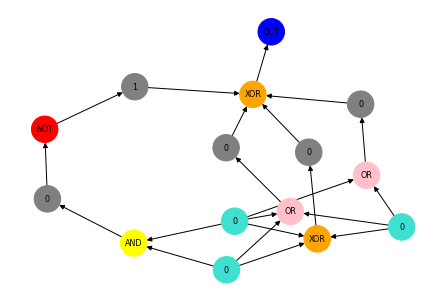

In [20]:
S = calculate_input(C)
if S:
    draw_circuit(C)
print("X =",S)

#### Calcular vetor de input X' aceite pelo circuito que está mais próximo de X

X' = [0, 1, 0]


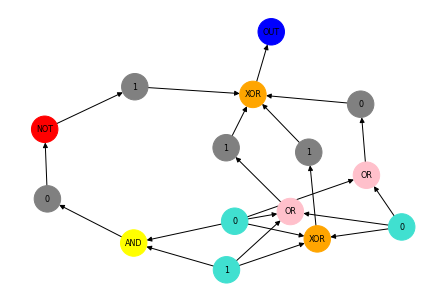

In [21]:
NS = next_solution(C,S)
if NS:
    draw_circuit(C)
print("X' =", NS)

## Exemplo 4

#### Gerar circuito

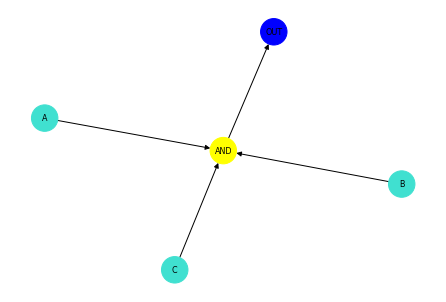

In [22]:
C = circuit_generator(3,1)
draw_circuit(C)

#### Calcular vetor de input X aceite pelo circuito

X = [1, 1, 1]


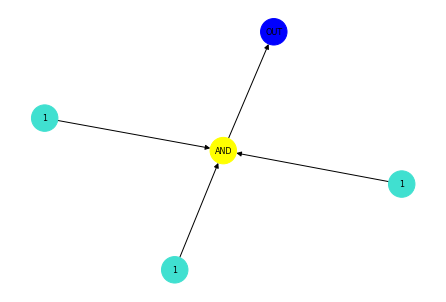

In [23]:
S = calculate_input(C)
if S:
    draw_circuit(C)
print("X =",S)

#### Calcular vetor de input X' aceite pelo circuito que está mais próximo de X

In [24]:
NS = next_solution(C,S)
if NS:
    draw_circuit(C)
print("X' =", NS)

X' = None
